# Modelling

In [2]:
# match data with aggregated individual data
import pandas as pd
match_path = '/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/player_data/data/matches_with_player_agg.csv'
players_path = '/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/player_data/data/players_with_player_stat_totals.csv'
matches = pd.read_csv(match_path)
players = pd.read_csv(players_path)

## Data Preparation

For the first iteration, we'll only use data after 2009. This is when most modern statistics began to be kept (though not all of them did).

In [380]:
model_data = matches[matches['season'] >= 2010]

To keep model simple, exclude draws. Mark them as victories for the away team instead.

In [381]:
for idx, row in model_data.iterrows():
    if row['winner'] == 'draw':
        model_data.at[idx,'winner'] = 'away'

We want to split the data into test and train in a stratified manner, i.e. we don't want to favour a certain season, or a part of the season. So we'll take a portion (25%) of games from each round.

In [382]:
# How many games do we get per round?
round_counts = {}
curr_round = 1
matches_in_round = 0
for idx,row in model_data.iterrows():
    
    if curr_round != row['round']:
        
        if matches_in_round not in round_counts:
            round_counts[matches_in_round] = 1
        else:
            round_counts[matches_in_round] += 1
            
        curr_round = row['round']
        matches_in_round = 1
        continue
        
    else:
        matches_in_round += 1
        
round_counts

{8: 44, 7: 7, 9: 157, 6: 22}

In [383]:
# Taking a minimum 25% of each round
from math import ceil
test_sample_size = {}
for num_games in round_counts:
    test_sample_size[num_games] = ceil(num_games/4)

In [384]:
rounds_in_season = get_season_rounds(model_data)
teams_in_season = get_season_teams(model_data)

Create test and training data

In [385]:
# test set
from copy import deepcopy

test_data = pd.DataFrame()
for season, max_round in rounds_in_season.items():
    for rnd in range(1, max_round):
        round_matches = model_data[(model_data['season']==season) & (model_data['round']==rnd)]
        num_test = test_sample_size[len(round_matches)]
        round_test_set = round_matches.sample(num_test)
        test_data = test_data.append(round_test_set)
        
# training set
training_data = model_data.drop(test_data.index)

Capture all of the 'diff' columns in the model, too

In [604]:
diff_cols = [col for col in model_data.columns if col[0:4] == 'diff']

Define features

In [599]:
features = [col 
            for col 
            in ['h_career_' + col for col in player_cols_to_agg] + \
            ['h_season_' + col for col in player_cols_to_agg] + \
            ['a_career_' + col for col in player_cols_to_agg] + \
            ['a_season_' + col for col in player_cols_to_agg] + \
            ['h_' + col for col in ladder_cols] + \
            ['h_' + col + '_form' for col in ladder_cols] + \
            ['a_' + col for col in ladder_cols] + \
            ['a_' + col + '_form' for col in ladder_cols] + \
            ['h_career_' + col for col in misc_columns] + \
            ['h_season_' + col for col in misc_columns] + \
            ['a_career_' + col for col in misc_columns] + \
            ['a_season_' + col for col in misc_columns] + \
            diff_cols
            ]

# REMOVE PERCENTAGE FOR NOW
features.remove('h_percentage')
features.remove('a_percentage')
features.remove('diff_percentage')

target = 'winner'

Set up test and train datasets

In [600]:
X_train = training_data[features]
y_train = training_data[target]
X_test = test_data[features]
y_test = test_data[target]

Fill the NaN values

In [427]:
X_train.fillna(0,inplace=True)
y_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)
y_test.fillna(0,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


## Modelling

Model 1: Logistic regression

In [428]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

log_reg = LogisticRegression()

param_grid = {
                 'tol': [.0001, .001, .01],
                 'C': [.1, 1, 10],
                 'max_iter': [50,100,200]
             }

grid_log_reg = GridSearchCV(log_reg, param_grid, cv=5)
grid_log_reg.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lb

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [50, 100, 200],
                         'tol': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [545]:
grid_log_reg.score(X_train,y_train)

0.7320644216691069

In [546]:
grid_log_reg.score(X_test,y_test)

0.66553480475382

In [431]:
# Confirm that it's not just picking the home team
print(sum(grid_log_reg.predict(X_test)=='away'))
print(sum(grid_log_reg.predict(X_test)=='home'))

240
349


Model 2: using less features

In [605]:
diff_cols = [col for col in model_data.columns if col[0:4] == 'diff']

In [606]:
features = diff_cols

# REMOVE PERCENTAGE FOR NOW
diff_cols.remove('diff_percentage')

target = 'winner'

In [609]:
X_train_2 = training_data[diff_cols]
y_train_2 = training_data[target]
X_test_2 = test_data[diff_cols]
y_test_2 = test_data[target]

#X_train_2 = X_train_2[features]
#y_train_2 = y_train_2[features]
#X_test_2 = X_test_2[features]
#y_test_2 = y_test_2[features]

X_train_2.fillna(0,inplace=True)
y_train_2.fillna(0,inplace=True)
X_test_2.fillna(0,inplace=True)
y_test_2.fillna(0,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [610]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

log_reg_2 = LogisticRegression()

param_grid = {
                 'tol': [.0001, .001, .01],
                 'C': [.1, 1, 10],
                 'max_iter': [50,100,200]
             }

grid_log_reg_2 = GridSearchCV(log_reg_2, param_grid, cv=5)
grid_log_reg_2.fit(X_train_2, y_train_2)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [50, 100, 200],
                         'tol': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [611]:
grid_log_reg_2.score(X_train_2,y_train_2)

0.7364568081991215

In [612]:
grid_log_reg_2.score(X_test_2,y_test_2)

0.6587436332767402

In [394]:
training_data[(training_data['round']==1) & (training_data['season']==2018)]

,Unnamed: 0,Unnamed: 0.1,round,venue,date,day,time,crowd,hteam,hteam_q1,hteam_q2,hteam_q3,hteam_q4,ateam,ateam_q1,ateam_q2,ateam_q3,ateam_q4,umpire1,umpire2,umpire3,umpire1games,umpire2games,umpire3games,hteam_et,ateam_et,season,matchid,homeodds,homeline,awayodds,awayline,hscore,ascore,hteam_q1_goals,hteam_q1_behinds,hteam_q1_score,hteam_q2_goals,hteam_q2_behinds,hteam_q2_score,hteam_q3_goals,hteam_q3_behinds,hteam_q3_score,hteam_q4_goals,hteam_q4_behinds,hteam_q4_score,ateam_q1_goals,ateam_q1_behinds,ateam_q1_score,ateam_q2_goals,ateam_q2_behinds,ateam_q2_score,ateam_q3_goals,ateam_q3_behinds,ateam_q3_score,ateam_q4_goals,ateam_q4_behinds,ateam_q4_score,winner,h_ladder_obj,a_ladder_obj,h_prem_points,a_prem_points,h_losses,a_losses,h_draws,a_draws,h_points_for,a_points_for,h_points_against,a_points_against,h_played,a_played,h_position,a_position,h_percentage,a_percentage,h_wins,a_wins,h_prem_points_form,h_losses_form,h_draws_form,h_points_for_form,h_points_against_form,h_played_form,h_position_form,h_percentage_form,h_wins_form,a_prem_points_form,a_losses_form,a_draws_form,a_points_for_form,a_points_against_form,a_played_form,a_position_form,a_percentage_form,a_wins_form,h_AFLfantasy,h_Supercoach,h_behinds,h_bounces,h_brownlow,h_clangers,h_clearances,h_contested_marks,h_contested_poss,h_disposals,h_frees_against,h_frees_for,h_goal_assists,h_goals,h_handballs,h_hitouts,h_inside50,h_kicks,h_marks,h_marks_in_50,h_one_percenters,h_rebound50,h_tackles,h_tog,h_uncontested_poss,h_centre_clearances,h_disposal_efficiency,h_effective_disposals,h_intercepts,h_metres_gained,h_stoppage_clearances,h_score_involvements,h_tackles_in_50,h_turnovers,h_career_AFLfantasy,h_career_Supercoach,h_career_behinds,h_career_bounces,h_career_brownlow,h_career_clangers,h_career_clearances,h_career_contested_marks,h_career_contested_poss,h_career_disposals,h_career_frees_against,h_career_frees_for,h_career_goal_assists,h_career_goals,h_career_handballs,h_career_hitouts,h_career_inside50,h_career_kicks,h_career_marks,h_career_marks_in_50,h_career_one_percenters,h_career_rebound50,h_career_tackles,h_career_tog,h_career_uncontested_poss,h_career_centre_clearances,h_career_disposal_efficiency,h_career_effective_disposals,h_career_intercepts,h_career_metres_gained,h_career_stoppage_clearances,h_career_score_involvements,h_career_tackles_in_50,h_career_turnovers,h_season_AFLfantasy,h_season_Supercoach,h_season_behinds,h_season_bounces,h_season_brownlow,h_season_clangers,h_season_clearances,h_season_contested_marks,h_season_contested_poss,h_season_disposals,h_season_frees_against,h_season_frees_for,h_season_goal_assists,h_season_goals,h_season_handballs,h_season_hitouts,h_season_inside50,h_season_kicks,h_season_marks,h_season_marks_in_50,h_season_one_percenters,h_season_rebound50,h_season_tackles,h_season_tog,h_season_uncontested_poss,h_season_centre_clearances,h_season_disposal_efficiency,h_season_effective_disposals,h_season_intercepts,h_season_metres_gained,h_season_stoppage_clearances,h_season_score_involvements,h_season_tackles_in_50,h_season_turnovers,h_career_games_played,h_season_games_played,a_AFLfantasy,a_Supercoach,a_behinds,a_bounces,a_brownlow,a_clangers,a_clearances,a_contested_marks,a_contested_poss,a_disposals,a_frees_against,a_frees_for,a_goal_assists,a_goals,a_handballs,a_hitouts,a_inside50,a_kicks,a_marks,a_marks_in_50,a_one_percenters,a_rebound50,a_tackles,a_tog,a_uncontested_poss,a_centre_clearances,a_disposal_efficiency,a_effective_disposals,a_intercepts,a_metres_gained,a_stoppage_clearances,a_score_involvements,a_tackles_in_50,a_turnovers,a_career_AFLfantasy,a_career_Supercoach,a_career_behinds,a_career_bounces,a_career_brownlow,a_career_clangers,a_career_clearances,a_career_contested_marks,a_career_contested_poss,a_career_disposals,a_career_frees_against,a_career_frees_for,a_career_goal_assists,a_career_goals,a_career_handballs,a_career_hitouts,a_career_inside50,a_career_kicks,a_career_marks,a_career_marks_in_50,a_career_one_percenters,a_ca

## Training model on all of the data

## Generating predictions

Now that we have a model, we need to ingest data for that model to make a prediction on.

Start by reading in the fixture.

In [395]:
fixture_path = '/Users/t_raver9/Desktop/projects/aflengine/tipengine/fixture2020.csv'
fixture = pd.read_csv(fixture_path)

In [396]:
fixture[fixture['round']==2]

,Unnamed: 0,round,date,venue,hometeam,awayteam,homescore,awayscore,winner
9,9,2,11/06/2020 19:40,MCG,Collingwood,Richmond,NaN,NaN,NaN
10,10,2,12/06/2020 19:50,GMHBA Stadium,Geelong,Hawthorn,NaN,NaN,NaN
11,11,2,13/06/2020 13:45,Gabba,Brisbane Lions,Fremantle,NaN,NaN,NaN
12,12,2,13/06/2020 16:35,Marvel Stadium,Carlton,Melbourne,NaN,NaN,NaN
13,13,2,13/06/2020 19:40,Metricon Stadium,Gold Coast,West Coast,NaN,NaN,NaN
14,14,2,13/06/2020 19:40,Adelaide Oval,Port Adelaide,Adelaide,NaN,NaN,NaN
15,15,2,14/06/2020 13:05,GIANTS Stadium,Greater Western Sydney,North Melbourne,NaN,NaN,NaN
16,16,2,14/06/2020 15:35,SCG,Sydney,Essendon,NaN,NaN,NaN
17,17,2,14/06/2020 18:05,Marvel Stadium,St Kilda,Footscray,NaN,NaN,NaN


We'll then prepare the data for the round we're interested in. We'll do this by:
- getting the team-level data, such as ladder position and form
- getting the player-level data and aggregating it up to the team level

To get the player-level data, we also need to choose who is playing for each team.

In [432]:
next_round_matches = get_upcoming_matches(matches,fixture,round_num=2)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [433]:
next_round_matches

,a_draws,a_draws_form,a_losses,a_losses_form,a_percentage,a_percentage_form,a_played,a_played_form,a_points_against,a_points_against_form,a_points_for,a_points_for_form,a_position,a_position_form,a_prem_points,a_prem_points_form,a_wins,a_wins_form,ateam,h_draws,h_draws_form,h_losses,h_losses_form,h_percentage,h_percentage_form,h_played,h_played_form,h_points_against,h_points_against_form,h_points_for,h_points_for_form,h_position,h_position_form,h_prem_points,h_prem_points_form,h_wins,h_wins_form,hteam
0,0,0,0,0,129.63,140.554,0,5,81,397,105,558,1,0,4,24,1,6,Richmond,0,0,0,2,252.941,130.788,0,5,34,406,86,531,1,4,4,16,1,4,Collingwood
0,0,0,0,2,145.161,134.584,0,5,62,373,90,502,1,-1,4,16,1,4,Hawthorn,0,0,1,4,69.5238,98.0176,0,5,105,454,73,445,1,2,0,8,0,2,Geelong
0,0,0,1,4,90.4762,88.1432,0,5,63,447,57,394,1,1,0,8,0,2,Fremantle,0,0,1,1,68.8889,128.009,0,5,90,432,62,553,1,-1,0,20,0,5,Brisbane Lions
0,0,0,1,6,65.3846,69.4915,0,5,78,531,51,369,1,2,0,0,0,0,Melbourne,0,0,1,3,77.1429,96.875,0,5,105,480,81,465,1,0,0,12,0,3,Carlton
0,0,0,0,1,152.941,126.351,0,5,51,444,78,561,1,0,4,20,1,5,West Coast,0,0,1,6,38.1579,53.092,0,5,76,663,29,352,1,1,0,0,0,0,Gold Coast
0,0,0,1,5,95.9459,80.226,0,5,74,531,71,426,1,4,0,4,0,1,Adelaide,0,0,0,3,262.069,106.181,0,5,29,453,76,481,1,3,4,12,1,3,Port Adelaide
0,0,0,0,3,103.704,98.6755,0,5,54,453,56,447,1,1,4,12,1,3,North Melbourne,0,0,0,2,143.836,92.9293,0,5,73,495,105,460,1,1,4,16,1,4,Greater Western Sydney
0,0,0,0,2,110.526,82.7839,0,5,57,546,63,452,1,0,4,16,1,4,Essendon,0,0,0,4,104.225,95.4148,0,5,71,458,74,437,1,2,4,8,1,2,Sydney
0,0,0,1,3,39.5349,124.784,0,5,86,464,34,579,1,-1,0,12,0,3,Footscray,0,0,1,3,96.4286,103.198,0,5,56,469,54,484,1,0,0,12,0,3,St Kilda


Get the IDs for the players we'll be using

In [70]:
import cv2 
import pytesseract
custom_config = r'--oem 3 --psm 6'

In [71]:
import pathlib
names_dir = '/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images'

# Initialise the dictionary
player_names_dict = {}
for team in matches['hteam'].unique():
    player_names_dict[team] = []
    
# Fill out the dictionary
for path in pathlib.Path(names_dir).iterdir():
    print(path)
    if path.name.split('.')[0] in player_names_dict:
        path_str = str(path)
        image_obj = cv2.imread(path_str)
        image_string = pytesseract.image_to_string(image_obj, config=custom_config)
        names = get_player_names(image_string)
        player_names_dict[path.name.split('.')[0]].extend(names)

/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/St Kilda.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Hawthorn.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Adelaide.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/.DS_Store
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Gold Coast.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Essendon.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Collingwood.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/North Melbourne.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Geelong.png
/Users/t_raver9/Desktop/projects/aflengine/analysis/machine_learning/src/OCR/images/Melbourne.png
/Users/t_raver9/Deskt

Try including Bachar Houli

Now we can collect the data for each player and aggregate it to the team level, as we would with the training data

In [629]:
from copy import deepcopy

players_in_rnd = []
for _, v in player_names_dict.items():
    players_in_rnd.extend(v)

player_data = get_player_data(players_in_rnd)

In [623]:
players_in_rnd

['Jack_Crisp',
 'Jordan_Roughead',
 'Jeremy_Howe',
 'Brayden_Maynard',
 'Darcy_Moore',
 'John_Noble',
 'Will_Hoskin-Elliott',
 'Scott_Pendlebury',
 'Chris_Mayne',
 'Tom_Phillips',
 'Brody_Mihocek',
 'Callum_L._Brown',
 'Jordan_De_Goey',
 'Mason_Cox',
 'Jamie_Elliott',
 'Brodie_Grundy',
 'Taylor_Adams',
 'Steele_Sidebottom',
 'Tyler_Brown',
 'Josh_Thomas',
 'Josh_Daicos',
 'Jack_Madgen',
 'Harry_Taylor',
 'Mark_Blicavs',
 'Jack_Henry',
 "Mark_O'Connor",
 'Tom_Stewart',
 'Zach_Tuohy',
 'Sam_Menegola',
 'Patrick_Dangerfield',
 'Zach_Guthrie',
 'Luke_Dahlhaus',
 'Gryan_Miers',
 'Tom_Atkins',
 'Gary_Rohan',
 'Tom_Hawkins',
 'Esava_Ratugolea',
 'Darcy_Fort',
 'Joel_Selwood',
 'Quinton_Narkle',
 'Gary_Ablett',
 'Jordan_Clark',
 'Mitch_Duncan',
 'Cameron_Guthrie',
 'Neville_Jetta',
 'Steven_May',
 'Jake_Lever',
 'Oscar_McDonald',
 'James_Harmes',
 'Michael_Hibberd',
 'Ed_Langdon',
 'Clayton_Oliver',
 'Adam_Tomlinson',
 'Alex_Neal-Bullen',
 'Bayley_Fritsch',
 'Jack_Viney',
 'Kysaiah_Pickett',
 

In [630]:
aggregate = player_data[player_cols].groupby('team').apply(lambda x: x.mean(skipna=False))

# Factor in any missing players
num_players_per_team = player_data[player_cols].groupby('team').count()['Supercoach']
for team in num_players_per_team.index:
    aggregate.loc[team] = aggregate.loc[team] * (22/num_players_per_team[team])
    
aggs_h = deepcopy(aggregate)
aggs_a = deepcopy(aggregate)
aggs_h.columns = aggregate.columns.map(lambda x: 'h_' + str(x))
aggs_a.columns = aggregate.columns.map(lambda x: 'a_' + str(x))
combined = next_round_matches.merge(aggs_h, left_on='hteam', right_on='team')
combined = combined.merge(aggs_a, left_on='ateam', right_on='team')
combined = get_diff_cols(combined)

Creating differential columns


In [243]:
pd.set_option('max_columns',500)

Can now use this to make predictions

In [584]:
X = combined[features]

In [621]:
X['diff_wins_form']

0    -2
1    -2
2     3
3     3
4    -5
5     2
6     1
7    -2
8     0
Name: diff_wins_form, dtype: object

In [586]:
grid_log_reg.decision_function(X)

array([ 2.18691532,  1.37470342,  1.11917108,  0.66185405, -2.39513797,
        1.33866622,  0.78912168,  2.19572299,  1.22276119])

In [587]:
grid_log_reg.predict_proba(X)

array([[0.10093167, 0.89906833],
       [0.201861  , 0.798139  ],
       [0.24616507, 0.75383493],
       [0.34032325, 0.65967675],
       [0.9164558 , 0.0835442 ],
       [0.20772948, 0.79227052],
       [0.31235729, 0.68764271],
       [0.10013522, 0.89986478],
       [0.2274509 , 0.7725491 ]])

In [544]:
grid_log_reg.predict(X)

array(['home', 'home', 'home', 'home', 'away', 'home', 'home', 'home',
       'home'], dtype=object)

In [631]:
Z = combined[diff_cols]

In [632]:
grid_log_reg_2.predict_proba(Z)

array([[0.4930878 , 0.5069122 ],
       [0.19543377, 0.80456623],
       [0.4272651 , 0.5727349 ],
       [0.37611653, 0.62388347],
       [0.90095979, 0.09904021],
       [0.57961074, 0.42038926],
       [0.37417013, 0.62582987],
       [0.24824787, 0.75175213],
       [0.18824438, 0.81175562]])

In [628]:
grid_log_reg_2.predict(Z)

array(['home', 'home', 'home', 'home', 'away', 'away', 'home', 'home',
       'home'], dtype=object)

In [442]:
combined[['ateam','hteam']]

,ateam,hteam
0,Richmond,Collingwood
1,Hawthorn,Geelong
2,Fremantle,Brisbane Lions
3,Melbourne,Carlton
4,West Coast,Gold Coast
5,Adelaide,Port Adelaide
6,North Melbourne,Greater Western Sydney
7,Essendon,Sydney
8,Footscray,St Kilda


In [669]:
combined[['h_percentage_form','a_percentage_form']]

,h_percentage_form,a_percentage_form
0,130.788,140.554
1,98.0176,134.584
2,128.009,88.1432
3,96.875,69.4915
4,53.092,126.351
5,106.181,80.226
6,92.9293,98.6755
7,95.4148,82.7839
8,103.198,124.784


In [670]:
combined[['h_career_games_played','a_career_games_played']]

,h_career_games_played,a_career_games_played
0,127.490305,114.839002
1,142.049383,150.657596
2,89.895692,66.110000
3,102.409091,92.839002
4,65.351474,139.260000
5,118.780045,106.891967
6,111.297052,118.929705
7,82.088643,81.818182
8,89.863636,79.569161


In [671]:
combined[['h_wins_form','a_wins_form']]

,h_wins_form,a_wins_form
0,4,6
1,2,4
2,5,2
3,3,0
4,0,5
5,3,1
6,4,3
7,2,4
8,3,3


In [462]:
model_coef = grid_log_reg.best_estimator_.coef_

In [666]:
X['diff_season_Supercoach']

0    17.995666
1     3.165029
2    -5.998492
3    -4.831066
4   -26.481689
5    13.889624
6     4.988662
7    13.484765
8    11.202845
Name: diff_season_Supercoach, dtype: float64

Glue these together and sort

In [494]:
coef = []
for i in model_coef:
    for j in i:
        coef.append(abs(j))

In [495]:
zipped = list(zip(features,coef))

In [498]:
zipped.sort(key = lambda x: x[1],reverse=True)

In [499]:
zipped

[('diff_career_games_played', 0.018679524004238286),
 ('diff_position_form', 0.016984315503218023),
 ('h_position', 0.014634606882942082),
 ('h_season_Supercoach', 0.014512740107793912),
 ('a_career_games_played', 0.014451903484145072),
 ('diff_season_Supercoach', 0.013427652741972605),
 ('diff_career_Supercoach', 0.013151735740817329),
 ('diff_position', 0.012234949408804928),
 ('a_prem_points', 0.011714495831821303),
 ('diff_disposal_efficiency', 0.010124466475484564),
 ('diff_Supercoach', 0.009680275396626983),
 ('h_career_games_played', 0.009040122862152031),
 ('diff_prem_points', 0.008516843589636154),
 ('a_career_Supercoach', 0.008336092390940512),
 ('diff_season_disposal_efficiency', 0.00764210077540178),
 ('diff_AFLfantasy', 0.007168121175197372),
 ('diff_career_tog', 0.0071669584565377574),
 ('h_career_tog', 0.006972579618562823),
 ('a_season_disposal_efficiency', 0.00691301221185097),
 ('h_career_Supercoach', 0.006770059824541597),
 ('a_percentage_form', 0.006246272931104387)

## Training model on all data

In [554]:
features = [col 
            for col 
            in ['h_career_' + col for col in player_cols_to_agg] + \
            ['h_season_' + col for col in player_cols_to_agg] + \
            ['a_career_' + col for col in player_cols_to_agg] + \
            ['a_season_' + col for col in player_cols_to_agg] + \
            ['h_' + col for col in ladder_cols] + \
            ['h_' + col + '_form' for col in ladder_cols] + \
            ['a_' + col for col in ladder_cols] + \
            ['a_' + col + '_form' for col in ladder_cols] + \
            ['h_career_' + col for col in misc_columns] + \
            ['h_season_' + col for col in misc_columns] + \
            ['a_career_' + col for col in misc_columns] + \
            ['a_season_' + col for col in misc_columns] + \
            diff_cols
            ]

# REMOVE PERCENTAGE FOR NOW
features.remove('h_percentage')
features.remove('a_percentage')
features.remove('diff_percentage')

target = 'winner'

In [555]:
X = model_data[features]
y = model_data[target]

In [556]:
X.fillna(0,inplace=True)
y.fillna(0,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [633]:
grid_log_reg_2.predict_proba(Z)

array([[0.4930878 , 0.5069122 ],
       [0.19543377, 0.80456623],
       [0.4272651 , 0.5727349 ],
       [0.37611653, 0.62388347],
       [0.90095979, 0.09904021],
       [0.57961074, 0.42038926],
       [0.37417013, 0.62582987],
       [0.24824787, 0.75175213],
       [0.18824438, 0.81175562]])

In [634]:
combined[['ateam','hteam']]

,ateam,hteam
0,Richmond,Collingwood
1,Hawthorn,Geelong
2,Fremantle,Brisbane Lions
3,Melbourne,Carlton
4,West Coast,Gold Coast
5,Adelaide,Port Adelaide
6,North Melbourne,Greater Western Sydney
7,Essendon,Sydney
8,Footscray,St Kilda


## Visualisation

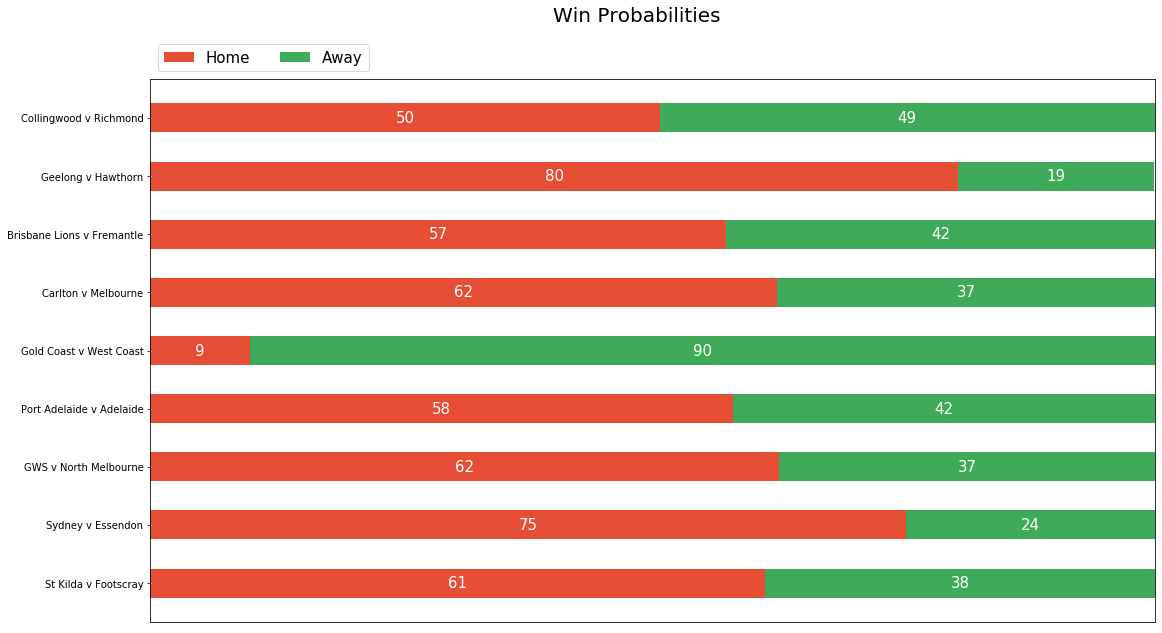

In [662]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


category_names = ['Home','Away']
results = {
    'Collingwood v Richmond': [50.7,49.3],
    'Geelong v Hawthorn': [80.4,19.5],
    'Brisbane Lions v Fremantle': [57.3,42.7],
    'Carlton v Melbourne': [62.4,37.6],
    'Gold Coast v West Coast': [9.9,90.1],
    'Port Adelaide v Adelaide': [58.0,42.0],
    'GWS v North Melbourne': [62.6,37.4],
    'Sydney v Essendon': [75.2,24.8],
    'St Kilda v Footscray': [61.2,38.8]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(18, 10))
    fig.suptitle('Win Probabilities', fontsize=20)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color,fontsize=15)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=15)

    return fig, ax


survey(results, category_names)
plt.show()

In [638]:
plt.show()

# Metadata and functions

In [7]:
from typing import Dict
import numpy as np

def get_season_rounds(matches: pd.DataFrame) -> Dict:
    """
    Return a dictionary with seasons as keys and number of games
    in season as values
    """
    seasons = matches['season'].unique()
    rounds_in_season = dict.fromkeys(seasons,0)
    
    for season in seasons:
        rounds_in_season[season] = max(matches[matches['season']==season]['round'])
    
    return rounds_in_season

# What teams participated in each season?
def get_season_teams(matches: pd.DataFrame) -> Dict:
    """
    Return a dictionary with seasons as keys and a list of teams who played
    in that season as values
    """
    seasons = matches['season'].unique()
    teams_in_season = {}

    for season in seasons:
        teams = list(matches[matches['season']==season]['hteam'].unique())
        teams.extend(list(matches[matches['season']==season]['ateam'].unique()))
        teams = np.unique(teams)
        teams_in_season[season] = list(teams)
        
    return teams_in_season

In [11]:
player_cols_to_agg = [
    'AFLfantasy',
    'Supercoach',
    'behinds',
    'bounces',
    'brownlow',
    'clangers',
    'clearances',
    'contested_marks',
    'contested_poss',
    'disposals',
    'frees_against',
    'frees_for',
    'goal_assists',
    'goals',
    'handballs',
    'hitouts',
    'inside50',
    'kicks',
    'marks',
    'marks_in_50',
    'one_percenters',
    'rebound50',
    'tackles',
    'tog',
    'uncontested_poss',
    'centre_clearances',
    'disposal_efficiency',
    'effective_disposals',
    'intercepts',
    'metres_gained',
    'stoppage_clearances',
    'score_involvements',
    'tackles_in_50',
    'turnovers'
]

match_cols = [
    'odds',
    'line'
]

ladder_columns = [
    'wins',
    'losses',
    'draws',
    'prem_points',
    'played',
    'points_for',
    'points_against',
    'percentage',
    'position'
]

misc_columns = [
    'games_played'
]

diff_cols = [
    
]

In [350]:
def get_upcoming_matches(matches, fixture, round_num=None):
    
    if round_num == None: # Get the latest populated round
        round_num = matches['round'].iloc[-1] + 1
        
    fixture['round'] = fixture['round'].astype(str)
    next_round = fixture[fixture['round']==str(round_num)]
    
    # Get list of home and away
    matches.sort_values(by=['season','round'],ascending=False,inplace=True)
    teams = list(next_round['hometeam'])
    teams = list(zip(teams,list(next_round['awayteam']))) # (home, away)
    
    # Initialise upcoming round
    df = pd.DataFrame()
    output = pd.DataFrame(columns = h_ladder_cols + h_ladder_form_cols + a_ladder_cols + a_ladder_form_cols)
    
    # For each team, find the data that is relevant to them
    for team in teams:
        h_last_match = matches[(matches['hteam'] == team[0]) | (matches['ateam'] == team[0])].iloc[0]
        a_last_match = matches[(matches['hteam'] == team[1]) | (matches['ateam'] == team[1])].iloc[0]
        
        # Home team conditions, and use the 'game_cols' to update the ladder and ladder form for that team
        if team[0] == h_last_match['hteam']: # Home team was home team last game
            h_last_match_rel_cols = h_last_match[h_ladder_cols + h_ladder_form_cols + game_cols]
            h_last_match_rel_cols = update_ladder(h_last_match_rel_cols,'home')
        elif team[0] == h_last_match['ateam']: # Home team was away team last game
            h_last_match_rel_cols = h_last_match[a_ladder_cols + a_ladder_form_cols + game_cols]
            h_last_match_rel_cols = update_ladder(h_last_match_rel_cols,'away')
            
        # Away team conditions
        if team[1] == a_last_match['hteam']: # Away team was home team last game
            a_last_match_rel_cols = a_last_match[h_ladder_cols + h_ladder_form_cols + game_cols]
            a_last_match_rel_cols = update_ladder(a_last_match_rel_cols,'home')
        elif team[1] == a_last_match['ateam']: # Away team was away team last game
            a_last_match_rel_cols = a_last_match[a_ladder_cols + a_ladder_form_cols + game_cols]
            a_last_match_rel_cols = update_ladder(a_last_match_rel_cols,'away')
            
        h_last_match_rel_cols['hteam'] = team[0]
        a_last_match_rel_cols['ateam'] = team[1]
        
        # Make sure the columns are the right format
        h_col_final = []
        for col in h_last_match_rel_cols.index:
            if col[0] == 'h':
                h_col_final.append(col)
            else:
                col = 'h' + col[1:]
                h_col_final.append(col)
                
        a_col_final = []
        for col in a_last_match_rel_cols.index:
            if col[0] == 'a':
                a_col_final.append(col)
            else:
                col = 'a' + col[1:]
                a_col_final.append(col)   
        
        h_last_match_rel_cols.index = h_col_final
        a_last_match_rel_cols.index = a_col_final
            
        # Add all of these to the output.
        joined = pd.concat([h_last_match_rel_cols,a_last_match_rel_cols]).to_frame().T
        joined.drop('hscore',axis=1,inplace=True)
        joined.drop('ascore',axis=1,inplace=True)
        output = output.append(joined)
            
    matches.sort_values(by=['season','round'],ascending=True,inplace=True)
    return output

In [26]:
def update_ladder(last_match_rel_cols, last_game_h_a):
    if last_game_h_a == 'home':
        
        # Update wins, losses, draws and prem points
        if last_match_rel_cols['hscore'] > last_match_rel_cols['ascore']:
            last_match_rel_cols['h_wins'] = last_match_rel_cols['h_wins'] + 1
            last_match_rel_cols['h_wins_form'] = last_match_rel_cols['h_wins_form'] + 1
            last_match_rel_cols['h_prem_points'] = last_match_rel_cols['h_prem_points'] + 4
            last_match_rel_cols['h_prem_points_form'] = last_match_rel_cols['h_prem_points_form'] + 4
        elif last_match_rel_cols['hscore'] < last_match_rel_cols['ascore']:
            last_match_rel_cols['h_losses'] = last_match_rel_cols['h_losses'] + 1
            last_match_rel_cols['h_losses_form'] = last_match_rel_cols['h_losses_form'] + 1
        else:
            last_match_rel_cols['h_draws'] = last_match_rel_cols['h_draws'] + 1
            last_match_rel_cols['h_prem_points'] = last_match_rel_cols['h_prem_points'] + 2
            last_match_rel_cols['h_prem_points_form'] = last_match_rel_cols['h_prem_points_form'] + 2
            
        # Update points for and against
        last_match_rel_cols['h_points_for'] = last_match_rel_cols['h_points_for'] + last_match_rel_cols['hscore']
        last_match_rel_cols['h_points_against'] = last_match_rel_cols['h_points_against'] + last_match_rel_cols['ascore']
        last_match_rel_cols['h_points_for_form'] = last_match_rel_cols['h_points_for_form'] + last_match_rel_cols['hscore']
        last_match_rel_cols['h_points_against_form'] = last_match_rel_cols['h_points_against_form'] + last_match_rel_cols['ascore']
        
        # Update percentage
        last_match_rel_cols['h_percentage'] = (last_match_rel_cols['h_points_for'] / last_match_rel_cols['h_points_against']) * 100
        last_match_rel_cols['h_percentage_form'] = (last_match_rel_cols['h_points_for_form'] / last_match_rel_cols['h_points_against_form']) * 100
        
                
    if last_game_h_a == 'away':
        # Update wins, losses, draws and prem points
        if last_match_rel_cols['hscore'] > last_match_rel_cols['ascore']:
            last_match_rel_cols['a_losses'] = last_match_rel_cols['a_losses'] + 1
            last_match_rel_cols['a_losses_form'] = last_match_rel_cols['a_losses_form'] + 1
        elif last_match_rel_cols['hscore'] < last_match_rel_cols['ascore']:
            last_match_rel_cols['a_wins'] = last_match_rel_cols['a_wins'] + 1
            last_match_rel_cols['a_wins_form'] = last_match_rel_cols['a_wins_form'] + 1
            last_match_rel_cols['a_prem_points'] = last_match_rel_cols['a_prem_points'] + 4
            last_match_rel_cols['a_prem_points_form'] = last_match_rel_cols['a_prem_points_form'] + 4
        else:
            last_match_rel_cols['a_draws'] = last_match_rel_cols['a_draws'] + 1
            last_match_rel_cols['a_prem_points'] = last_match_rel_cols['a_prem_points'] + 2
            last_match_rel_cols['a_prem_points_form'] = last_match_rel_cols['a_prem_points_form'] + 2
            
        # Update points for and against
        last_match_rel_cols['a_points_for'] = last_match_rel_cols['a_points_for'] + last_match_rel_cols['ascore']
        last_match_rel_cols['a_points_against'] = last_match_rel_cols['a_points_against'] + last_match_rel_cols['hscore']
        last_match_rel_cols['a_points_for_form'] = last_match_rel_cols['a_points_for_form'] + last_match_rel_cols['ascore']
        last_match_rel_cols['a_points_against_form'] = last_match_rel_cols['a_points_against_form'] + last_match_rel_cols['hscore']
        
        # Update percentage
        last_match_rel_cols['a_percentage'] = (last_match_rel_cols['a_points_for'] / last_match_rel_cols['a_points_against']) * 100
        last_match_rel_cols['a_percentage_form'] = (last_match_rel_cols['a_points_for_form'] / last_match_rel_cols['a_points_against_form']) * 100
                
    return last_match_rel_cols

In [30]:
ladder_columns = {
    ('wins',0),
    ('losses',0),
    ('draws',0),
    ('prem_points',0),
    ('played',0),
    ('points_for',0),
    ('points_against',0),
    ('percentage',100),
    ('position',1)
}

ladder_cols = [i for i,j in ladder_columns]
h_ladder_cols = ['h_' + i for i,j in ladder_columns]
a_ladder_cols = ['a_' + i for i,j in ladder_columns]
h_ladder_form_cols = ['h_' + i + '_form' for i,j in ladder_columns]
a_ladder_form_cols = ['a_' + i + '_form' for i,j in ladder_columns]
h_ladder_form_cols_mapping = dict(zip(ladder_cols,h_ladder_form_cols))
a_ladder_form_cols_mapping = dict(zip(ladder_cols,a_ladder_form_cols))

game_cols = [
    'hscore',
    'ascore'
]

In [64]:
def update_last_game(df):
    for idx,row in df.iterrows():
        
        for col in cols_to_update:
            single_game_col = col[7:] # This is the non-aggregate column, e.g. 'Supercoach' instead of 'career_Supercoach'
            if col[0:7] == 'career_':
                df.at[idx,col] = (df.at[idx,single_game_col] + (df.at[idx,col] * (df.at[idx,'career_games_played']))) / df.at[idx,'career_games_played']
            elif col[0:7] == 'season_':
                df.at[idx,col] = (df.at[idx,single_game_col] + (df.at[idx,col] * (df.at[idx,'season_games_played']))) / df.at[idx,'season_games_played']
            else:
                raise Exception('Column not found, check what columns you\'re passing')
                
    return df

In [67]:
def get_player_names(image_string):
    """
    Returns the names of players who are named in a team
    """
    names = []
    name = ''
    i = 0
    while i <= len(image_string):
        if image_string[i] == ']':
            name = ''
            i += 2 # Skip the first space
        else:
            i += 1
            continue
        name = ''
        while (image_string[i] != ',') & (image_string[i] != '\n'):
            name += image_string[i]
            i += 1
            if i == len(image_string):
                break
        name = name.replace(' ','_')
        names.append(name)
        i += 1
    return names

In [89]:
def get_player_data(player_ids):
    last_games = pd.DataFrame(columns = players.columns)
    for player in player_ids:
        last_game_row = players[(players['playerid']==player) & (players['next_matchid'].isna())]
        last_games = last_games.append(last_game_row)
    return last_games

In [179]:
player_cols = ['AFLfantasy',
 'Supercoach',
 'behinds',
 'bounces',
 'brownlow',
 'clangers',
 'clearances',
 'contested_marks',
 'contested_poss',
 'disposals',
 'frees_against',
 'frees_for',
 'goal_assists',
 'goals',
 'handballs',
 'hitouts',
 'inside50',
 'kicks',
 'marks',
 'marks_in_50',
 'one_percenters',
 'rebound50',
 'tackles',
 'tog',
 'uncontested_poss',
 'centre_clearances',
 'disposal_efficiency',
 'effective_disposals',
 'intercepts',
 'metres_gained',
 'stoppage_clearances',
 'score_involvements',
 'tackles_in_50',
 'turnovers',
 'matchid',
 'next_matchid',
 'team',
 'career_AFLfantasy',
 'career_Supercoach',
 'career_behinds',
 'career_bounces',
 'career_brownlow',
 'career_clangers',
 'career_clearances',
 'career_contested_marks',
 'career_contested_poss',
 'career_disposals',
 'career_frees_against',
 'career_frees_for',
 'career_goal_assists',
 'career_goals',
 'career_handballs',
 'career_hitouts',
 'career_inside50',
 'career_kicks',
 'career_marks',
 'career_marks_in_50',
 'career_one_percenters',
 'career_rebound50',
 'career_tackles',
 'career_tog',
 'career_uncontested_poss',
 'career_centre_clearances',
 'career_disposal_efficiency',
 'career_effective_disposals',
 'career_intercepts',
 'career_metres_gained',
 'career_stoppage_clearances',
 'career_score_involvements',
 'career_tackles_in_50',
 'career_turnovers',
 'season_AFLfantasy',
 'season_Supercoach',
 'season_behinds',
 'season_bounces',
 'season_brownlow',
 'season_clangers',
 'season_clearances',
 'season_contested_marks',
 'season_contested_poss',
 'season_disposals',
 'season_frees_against',
 'season_frees_for',
 'season_goal_assists',
 'season_goals',
 'season_handballs',
 'season_hitouts',
 'season_inside50',
 'season_kicks',
 'season_marks',
 'season_marks_in_50',
 'season_one_percenters',
 'season_rebound50',
 'season_tackles',
 'season_tog',
 'season_uncontested_poss',
 'season_centre_clearances',
 'season_disposal_efficiency',
 'season_effective_disposals',
 'season_intercepts',
 'season_metres_gained',
 'season_stoppage_clearances',
 'season_score_involvements',
 'season_tackles_in_50',
 'season_turnovers',
 'career_games_played',
 'season_games_played']


In [275]:
def get_diff_cols(matches: pd.DataFrame) -> pd.DataFrame:
    """
    Function to take the columns and separate between home and away teams. Each
    metric will have a "diff" column which tells the difference between home
    and away for this metric. i.e. there's a diff_percentage column which tells
    the difference between home and away for the percentage
    """
    print('Creating differential columns')
    for col in matches.columns:
        if col[0:2] == 'h_':
            try:
                h_col = col
                a_col = 'a_' + col[2:]
                diff_col = 'diff_' + col[2:]
                matches[diff_col] = matches[h_col] - matches[a_col]
            except TypeError:
                pass
    return matches

In [366]:
from typing import Type
import pandas as pd

class TeamLadder:
    def __init__(self, team: str):
        self.team = team
        for column, init_val in ladder_columns:
            setattr(self, column, init_val)

    def add_prev_round_team_ladder(self, prev_round_team_ladder):
        for col,val in prev_round_team_ladder.items():
            self.__dict__[col] = val

    def update_home_team(self, match):
        self.played += 1
        if match.hscore > match.ascore:
            self.wins += 1
            self.prem_points += 4
        elif match.hscore == match.ascore:
            self.draws += 1
            self.prem_points += 2
        else:
            self.losses += 1    
        self.points_for += match.hscore
        self.points_against += match.ascore
        self.percentage = 100 * (self.points_for / self.points_against)

    def update_away_team(self, match):
        self.played += 1
        if match.hscore < match.ascore:
            self.wins += 1
            self.prem_points += 4
        elif match.hscore == match.ascore:
            self.draws += 1
            self.prem_points += 2
        else:
            self.losses += 1    
        self.points_for += match.ascore
        self.points_against += match.hscore
        self.percentage = 100 * (self.points_for / self.points_against)

    def update_ladder(self, match):
        """
        Update the ladder for the team based on the outcome of the game. There
        will be two possibilites - the team can be the home or the away team
        in the provided match.
        """
        if self.team == match.teams['home']:
            self.update_home_team(match)
        else:
            self.update_away_team(match)

class Ladder:
    """
    Each round object holds the ladder details for that round for each team
    """
    def __init__(self, teams_in_season):
        self.teams_in_season = teams_in_season
        self.team_ladders = {}

    def add_team_ladder(self, team_ladder):
        self.team_ladders[team_ladder.team.team] = team_ladder

class Team:
    """
    Holds team-level data for a particular match
    """
    def __init__(self, generic_team_columns, home_or_away: str):
        self.home_or_away = home_or_away
        for column in generic_team_columns:
            setattr(self, column, None)

    def add_data(self, data: pd.DataFrame):
        if self.home_or_away == 'home':
            for home_col, generic_col in home_cols_mapped.items():
                self.__dict__[generic_col] = data[home_col]
        if self.home_or_away == 'away':
            for away_col, generic_col in away_cols_mapped.items():
                self.__dict__[generic_col] = data[away_col]

class Match:
    """
    Holds data about a match, as well as an object for each team
    """
    def __init__(self, match_columns):
        self.teams = {
            'home': None,
            'away': None
        }
        for column in match_columns:
            setattr(self, column, None)

    def add_data(self, data: pd.DataFrame):
        for column in self.__dict__.keys():
            try:
                self.__dict__[column] = data[column]
            except KeyError:
                continue
    
    def add_home_team(self, team):
        self.teams['home'] = team
    
    def add_away_team(self, team):
        self.teams['away'] = team

class Round:
    """
    Contains match and ladder data for each round
    """
    def __init__(self, round_num: int):
        self.round_num = round_num
        self.matches = []
        self.bye_teams = []
        self.ladder = None

    def add_match(self, match):
        self.matches.append(match)

    def add_ladder(self, ladder):
        self.ladder = ladder

class Season:
    """
    Contains the rounds for a season, and which teams competed
    """
    def __init__(self, year: int, teams):
        self.year = year
        self.teams = teams
        self.rounds = {}
        
    def add_round(self, round_obj: Type[Round]):
        self.rounds[round_obj.round_num] = round_obj

class History:
    """
    Holds all season objects
    """
    def __init__(self):
        self.seasons = {}
        
    def add_season(self, season):
        self.seasons[season.year] = season

In [369]:
from typing import Dict
def get_season_num_games(matches: pd.DataFrame) -> Dict:
    """
    Return a dictionary with seasons as keys and number of games
    in season as values
    """
    seasons = matches['season'].unique()
    rounds_in_season = dict.fromkeys(seasons,0)
    
    for season in seasons:
        rounds_in_season[season] = max(matches[matches['season']==season]['h_played']) + 1
    
    return rounds_in_season